<h1><center>Model evaluation and Feature Importance</center></h1>

This notebook contains code for the following:
1. Read trained models and collate test results based on multiple scoring functions (F1-macro, F1-micro, F1-weighted and balanced accuracy)
2. Compare models with each other and mean baseline scores. Build visualizations for the same.
3. Examine best model through a confusion matrix to quantify biases and differences in prediction performance of majority and minority classes.
4. Global Feature Importance
5. Local Feature Importance

#### Import necessary libraries and set display options

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import joblib
import shap

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',200)

In [2]:
time_freq_domain_df = pd.read_csv('../data/time_freq_domain_windows.csv')
dct_domain_df = pd.read_csv('../data/dct_windows.csv')

### 1. Load and summarize test results of trained models

In [3]:
def split_predictably(df, exclftrs, target, groupftr, random_state):
    X = df.drop(columns=exclftrs)
    y = df[target]
    groups = df[groupftr]
    
    gss = GroupShuffleSplit(n_splits=1, test_size=6, random_state=random_state)
    other_index, test_index = next(gss.split(X, y, groups=groups))

    X_other, y_other, groups_other = X.iloc[other_index], y.iloc[other_index], groups.iloc[other_index]
    X_test, y_test, groups_test = X.iloc[test_index], y.iloc[test_index], groups.iloc[test_index]
    
    return X_other, X_test, y_other, y_test, groups_other, groups_test

def fetch_baseline_results(df, exclftrs, target, groupftr, random_state,
                           scorers):
    
    X_other, X_test, y_other, y_test, groups_other, groups_test = split_predictably(df, exclftrs, target,
                                                                                    groupftr, random_state)
    
    baseline_model = DummyClassifier()
    baseline_model.fit(X_other, y_other)
    y_pred_baseline = baseline_model.predict(X_test)
    
    results = {'y_pred_baseline':y_pred_baseline, 'random_state':random_state}
    results['scores'] = {}
    
    for key,scorer in scorers.items():
        results['scores'][key] = scorer._score_func(y_test, y_pred_baseline, **scorer._kwargs)
    
    return results

def add_result_scores(df, exclftrs, target, groupftr, result, 
                      scorers):
    """Add scores to grid of a trained model"""
    
    random_state = result['random_state']
    X_other, X_test, y_other, y_test, groups_other, groups_test = split_predictably(df, exclftrs, target, groupftr, random_state)
    
    result['scores'] = {}
    
    for key,scorer in scorers.items():
        result['scores'][key] = scorer._score_func(y_test, result['y_test_pred'], **scorer._kwargs )
        
    return result

# Defines all scores we wish to utilize to examine performance on test
scorers = {'accuracy':make_scorer(accuracy_score), 'balanced_accuracy':make_scorer(balanced_accuracy_score),
           'f1_macro':make_scorer(f1_score, average='macro'), 'f1_weighted':make_scorer(f1_score, average='weighted')}


#### 1.1 Summarize Logistic Regression

In [4]:
lr_timefreq_results = joblib.load('../results/lr_timefreq_results.pkl')

for result in lr_timefreq_results:
    result = add_result_scores(time_freq_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                                   target='class', groupftr='user', result=result,
                                   scorers=scorers)
    
lr_dct_results = joblib.load('../results/lr_dct_results.pkl')

for result in lr_dct_results:
    result = add_result_scores(dct_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                                   target='class', groupftr='user', result=result,
                                   scorers=scorers)



#### 1.2 Summarize Support Vector Classifiers

In [5]:
svc_timefreq_results = joblib.load('../results/svc_timefreq_results.pkl')

for result in svc_timefreq_results:
    result = add_result_scores(time_freq_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                               target='class', groupftr='user', result=result,
                               scorers=scorers)
    
svc_dct_results = joblib.load('../results/svc_dct_results.pkl')

for result in svc_dct_results:
    result = add_result_scores(dct_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                               target='class', groupftr='user', result=result,
                               scorers=scorers)



#### 1.3 Summarize Random Forest Classifiers (with time and frequency domain feature set)

In [6]:
rfc_timefreq_results = joblib.load('../results/rfc_timefreq_results.pkl')
for result in rfc_timefreq_results:
    result = add_result_scores(time_freq_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                               target='class', groupftr='user', result=result,
                               scorers=scorers)

rfc_dct_results = joblib.load('../results/rfc_dct_results.pkl')
for result in rfc_dct_results:
    result = add_result_scores(dct_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                               target='class', groupftr='user', result=result,
                               scorers=scorers)


#### 1.4 Summarize XGBoost Classifier (with time and frequency domain feature set)

In [7]:
xgb_timefreq_results = joblib.load('../results/xgb_timefreq_results.pkl')
for result in xgb_timefreq_results:
    result = add_result_scores(time_freq_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                               target='class', groupftr='user', result=result,
                               scorers=scorers)


xgb_dct_results = joblib.load('../results/xgb_dct_results.pkl')
for result in xgb_dct_results:
    result = add_result_scores(dct_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                               target='class', groupftr='user', result=result,
                               scorers=scorers)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


#### 1.5 Summarize Baseline Classifier

In [8]:
baseline_results = []
for i in range(len(lr_timefreq_results)):
    random_state = lr_timefreq_results[i]['random_state']
    baseline_result = fetch_baseline_results(time_freq_domain_df, exclftrs=['epoch_start','epoch_end','class','user'],
                                             target='class', groupftr='user', random_state=random_state,
                                             scorers=scorers)
    baseline_results.append(baseline_result)    

### 2. Performance comparison of models and baseline

#### 2.1 Performance comparison based on F1 macro scores

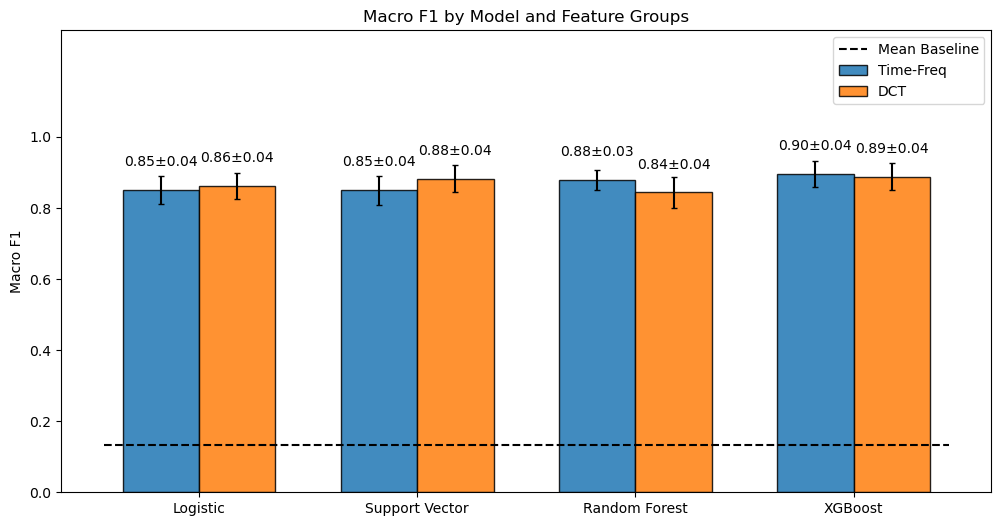

In [24]:
# Plot baseline F1 Macro and model F1 Macro comparison results

labels = ['Logistic', 'Support Vector', 'Random Forest', 'XGBoost']

timefreq_f1macro_means = [np.mean([result['scores']['f1_macro'] for result in lr_timefreq_results])]+\
                         [np.mean([result['scores']['f1_macro'] for result in svc_timefreq_results])]+\
                         [np.mean([result['scores']['f1_macro'] for result in rfc_timefreq_results])]+\
                         [np.mean([result['scores']['f1_macro'] for result in xgb_timefreq_results])]

timefreq_f1macro_std = [np.std([result['scores']['f1_macro'] for result in lr_timefreq_results])]+\
                       [np.std([result['scores']['f1_macro'] for result in svc_timefreq_results])]+\
                       [np.std([result['scores']['f1_macro'] for result in rfc_timefreq_results])]+\
                       [np.std([result['scores']['f1_macro'] for result in xgb_timefreq_results])]

dct_f1macro_means = [np.mean([result['scores']['f1_macro'] for result in lr_dct_results])]+\
                    [np.mean([result['scores']['f1_macro'] for result in svc_dct_results])]+\
                    [np.mean([result['scores']['f1_macro'] for result in rfc_dct_results])]+\
                    [np.mean([result['scores']['f1_macro'] for result in xgb_dct_results])]

dct_f1macro_std = [np.std([result['scores']['f1_macro'] for result in lr_dct_results])]+\
                  [np.std([result['scores']['f1_macro'] for result in svc_dct_results])]+\
                  [np.std([result['scores']['f1_macro'] for result in rfc_dct_results])]+\
                  [np.std([result['scores']['f1_macro'] for result in xgb_dct_results])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, timefreq_f1macro_means, width, label='Time-Freq', 
                alpha=0.85, color='tab:blue', edgecolor='k')
err1 = ax.errorbar(x - width/2, timefreq_f1macro_means, yerr=timefreq_f1macro_std, ls='none', 
                   marker=None, color='black', capthick=1, capsize = 2)

rects2 = ax.bar(x + width/2, dct_f1macro_means, width, label='DCT', 
                alpha=0.85, color='tab:orange', edgecolor='k')
err2 = ax.errorbar(x + width/2, dct_f1macro_means, yerr=dct_f1macro_std, ls='none',
                   marker=None, color='black', capthick=1, capsize=2)

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Macro F1')
ax.set_title('Macro F1 by Model and Feature Groups')
ax.tick_params(axis='y', which='major',labelsize=10)
ax.set_xticks(x, labels)
ax.set_ylim(0,1.3)
ax.set_yticks(ticks=np.linspace(0,1,6), labels=np.round(np.linspace(0,1,6),1))

ax.bar_label(rects1, labels=['{:.2f}±{:.2f}'.format(val[0],val[1]) for val in zip(timefreq_f1macro_means,timefreq_f1macro_std)],
             padding=15, label_type='edge', fontsize=10)

ax.bar_label(rects2, labels=['{:.2f}±{:.2f}'.format(val[0],val[1]) for val in zip(dct_f1macro_means,dct_f1macro_std)], 
             padding=15, label_type='edge', fontsize=10)

mean_baseline = np.mean([result['scores']['f1_macro'] for result in baseline_results])

ax.hlines(y=mean_baseline, xmin=x[0]-width*1.25, xmax=x[3]+width*1.25, color='k', 
          linestyles='dashed', label='Mean Baseline')
ax.legend()

file_name = 'model-comparison.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")


#### 2.2 Performance comparison based on accuracy (F1-micro) scores

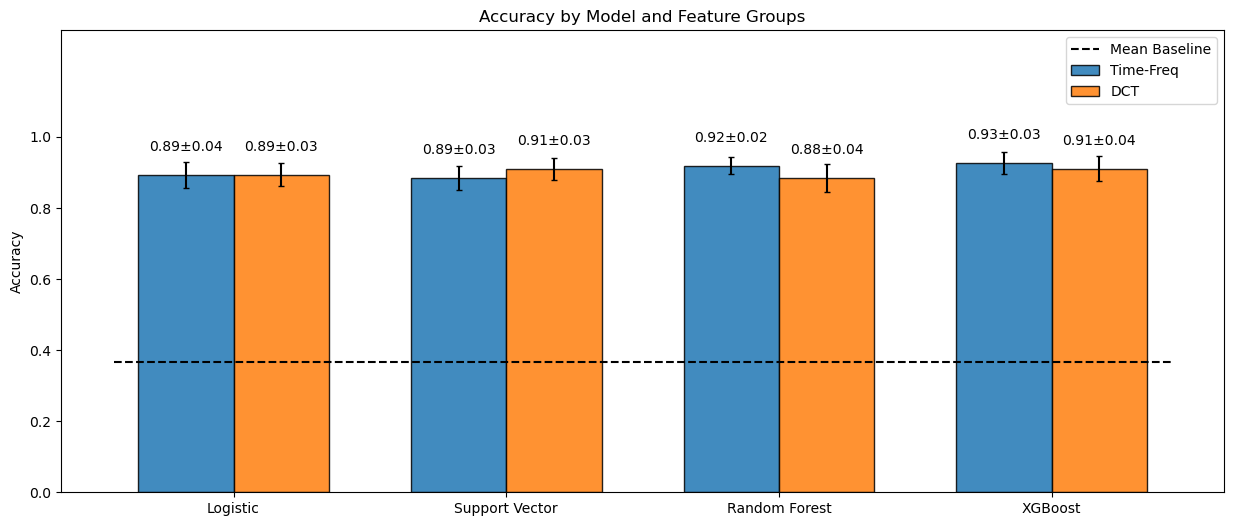

In [11]:
# Plot baseline accuracy and model accuracies comparison results

labels = ['Logistic', 'Support Vector', 'Random Forest', 'XGBoost']

timefreq_f1macro_means = [np.mean([result['scores']['accuracy'] for result in lr_timefreq_results])]+\
                         [np.mean([result['scores']['accuracy'] for result in svc_timefreq_results])]+\
                         [np.mean([result['scores']['accuracy'] for result in rfc_timefreq_results])]+\
                         [np.mean([result['scores']['accuracy'] for result in xgb_timefreq_results])]

timefreq_f1macro_std = [np.std([result['scores']['accuracy'] for result in lr_timefreq_results])]+\
                       [np.std([result['scores']['accuracy'] for result in svc_timefreq_results])]+\
                       [np.std([result['scores']['accuracy'] for result in rfc_timefreq_results])]+\
                       [np.std([result['scores']['accuracy'] for result in xgb_timefreq_results])]

dct_f1macro_means = [np.mean([result['scores']['accuracy'] for result in lr_dct_results])]+\
                    [np.mean([result['scores']['accuracy'] for result in svc_dct_results])]+\
                    [np.mean([result['scores']['accuracy'] for result in rfc_dct_results])]+\
                    [np.mean([result['scores']['accuracy'] for result in xgb_dct_results])]

dct_f1macro_std = [np.std([result['scores']['accuracy'] for result in lr_dct_results])]+\
                  [np.std([result['scores']['accuracy'] for result in svc_dct_results])]+\
                  [np.std([result['scores']['accuracy'] for result in rfc_dct_results])]+\
                  [np.std([result['scores']['accuracy'] for result in xgb_dct_results])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.bar(x - width/2, timefreq_f1macro_means, width, label='Time-Freq', 
                alpha=0.85, color='tab:blue', edgecolor='k')
err1 = ax.errorbar(x - width/2, timefreq_f1macro_means, yerr=timefreq_f1macro_std, ls='none', 
                   marker=None, color='black', capthick=1, capsize = 2)

rects2 = ax.bar(x + width/2, dct_f1macro_means, width, label='DCT', 
                alpha=0.85, color='tab:orange', edgecolor='k')
err2 = ax.errorbar(x + width/2, dct_f1macro_means, yerr=dct_f1macro_std, ls='none',
                   marker=None, color='black', capthick=1, capsize=2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model and Feature Groups')
ax.tick_params(axis='y', which='major',labelsize=10)
ax.set_xticks(x, labels)
ax.set_ylim(0,1.3)
ax.set_yticks(ticks=np.linspace(0,1,6), labels=np.round(np.linspace(0,1,6),1))

ax.bar_label(rects1, labels=['{:.2f}±{:.2f}'.format(val[0],val[1]) for val in zip(timefreq_f1macro_means,timefreq_f1macro_std)],
             padding=15, label_type='edge', fontsize=10)

ax.bar_label(rects2, labels=['{:.2f}±{:.2f}'.format(val[0],val[1]) for val in zip(dct_f1macro_means,dct_f1macro_std)], 
             padding=15, label_type='edge', fontsize=10)

mean_baseline = np.mean([result['scores']['accuracy'] for result in baseline_results])

ax.hlines(y=mean_baseline, xmin=x[0]-width*1.25, xmax=x[3]+width*1.25, color='k', 
          linestyles='dashed', label='Mean Baseline')
ax.legend()

file_name = 'model-comparison-acc.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")


### 3. Confusion Matrix of Best XGBoost Classifier

In [12]:
# Pick best XGBoost estimator

mean_f1 = np.mean([result['scores']['f1_macro'] for result in xgb_timefreq_results])
absf1_diff = np.abs(np.array([result['scores']['f1_macro'] for result in xgb_timefreq_results])-mean_f1)
repr_idx = np.argmin(absf1_diff)
reference_result = xgb_timefreq_results[repr_idx]
reference_random_state = reference_result['random_state']
reference_xgb = reference_result['grid'].best_estimator_[1]
reference_xgb_booster = reference_xgb.get_booster()


y_test_pred = reference_result['y_test_pred']
X_other, X_test, y_other, y_test, groups_other, groups_test = split_predictably(time_freq_domain_df, 
                                                                                exclftrs=['epoch_start','epoch_end','class','user'],
                                                                                target='class', groupftr='user', random_state=reference_random_state)


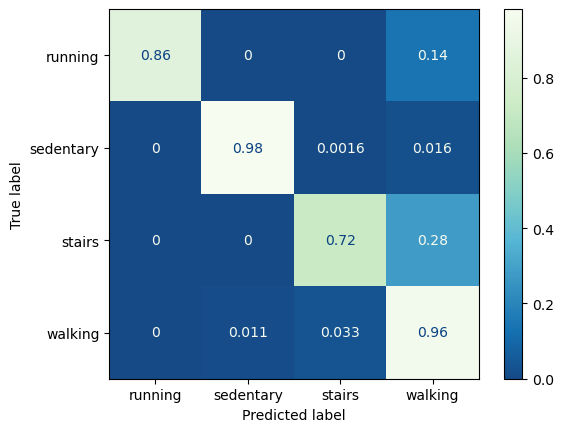

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize='true',
                                        cmap='GnBu_r', im_kw={'alpha':0.95})
file_name = 'xgb-cm.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")


### 4. Global Feature Importance

#### 4.1 Permutation Feature Importance

In [14]:
from sklearn.inspection import permutation_importance

std_scaler = StandardScaler()

xgb_pipe = make_pipeline(reference_result['grid'].best_estimator_[0],
                         reference_result['grid'].best_estimator_[1])
pi_result = permutation_importance(xgb_pipe, X_test, y_test,
                                   n_repeats=10, random_state=42,
                                   scoring=make_scorer(f1_score, average='macro'))

importances_idx = pi_result.importances_mean.argsort()
top10_features = np.array(X_test.columns)[importances_idx][-10:]
top10_importances = pi_result.importances[importances_idx][-10:]


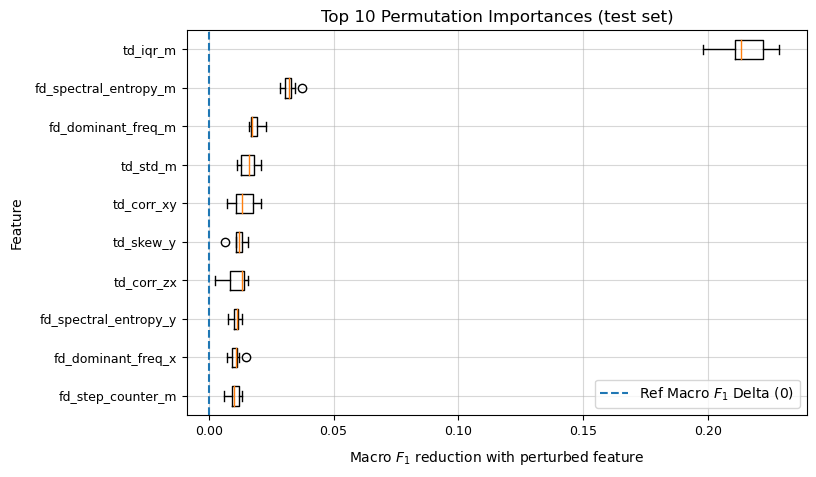

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot(x=top10_importances.tolist(), 
           labels=top10_features.tolist(), vert=False)

ax.axvline(0,label='Ref Macro $F_{1}$ Delta (0)',linestyle='--')
ax.set_title('Top 10 Permutation Importances (test set)')
ax.set_xlabel('Macro $F_{1}$ reduction with perturbed feature', 
              fontsize=10, labelpad=8)
ax.set_ylabel('Feature',fontsize=10, labelpad=8)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.grid(alpha=0.5)
ax.legend()
file_name = 'top10-permutation-importance.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
plt.show()

#### 4.2 XGBoost Classifier Relative Importance

In [16]:
gain_scores = reference_xgb_booster.get_score(importance_type='gain')
weight_scores = reference_xgb_booster.get_score(importance_type='weight')
cover_scores = reference_xgb_booster.get_score(importance_type='cover')
total_gain_scores = reference_xgb_booster.get_score(importance_type='total_gain')
total_cover_scores = reference_xgb_booster.get_score(importance_type='total_cover')


In [17]:
gain = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Gain'),
                  zip(X_other.columns.values.tolist(), gain_scores.values(),
                      [sum(gain_scores.values())]*len(gain_scores.values()))),
                    key=lambda x: x[1], reverse=True)

weight = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Weight'),
                    zip(X_other.columns.values.tolist(),weight_scores.values(),
                        [sum(weight_scores.values())]*len(weight_scores.values()))),
                      key=lambda x: x[1],reverse=True)


cover = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Cover'),
                   zip(X_other.columns.values.tolist(), cover_scores.values(),
                       [sum(cover_scores.values())]*len(cover_scores.values()))),
                    key=lambda x: x[1], reverse=True)

total_gain = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Total Gain'),
                        zip(X_other.columns.values.tolist(), total_gain_scores.values(),
                            [sum(total_gain_scores.values())]*len(total_gain_scores.values()))),
                    key=lambda x: x[1], reverse=True)

total_cover = sorted(map(lambda x: (x[0], x[1]/x[2], 'Normalized Total Cover'),
                         zip(X_other.columns.values.tolist(), total_cover_scores.values(),
                             [sum(total_cover_scores.values())]*len(total_cover_scores.values()))),
                    key=lambda x: x[1], reverse=True)


gain_df = pd.DataFrame(gain,columns=['encoded_colname', 'score', 'score_type'])
weight_df = pd.DataFrame(weight,columns=['encoded_colname', 'score', 'score_type'])
cover_df = pd.DataFrame(cover,columns=['encoded_colname', 'score', 'score_type'])
total_gain_df = pd.DataFrame(total_gain,columns=['encoded_colname', 'score', 'score_type'])
total_cover_df = pd.DataFrame(total_cover,columns=['encoded_colname', 'score', 'score_type'])
scores_list = [gain_df, weight_df, cover_df, total_gain_df, total_cover_df]


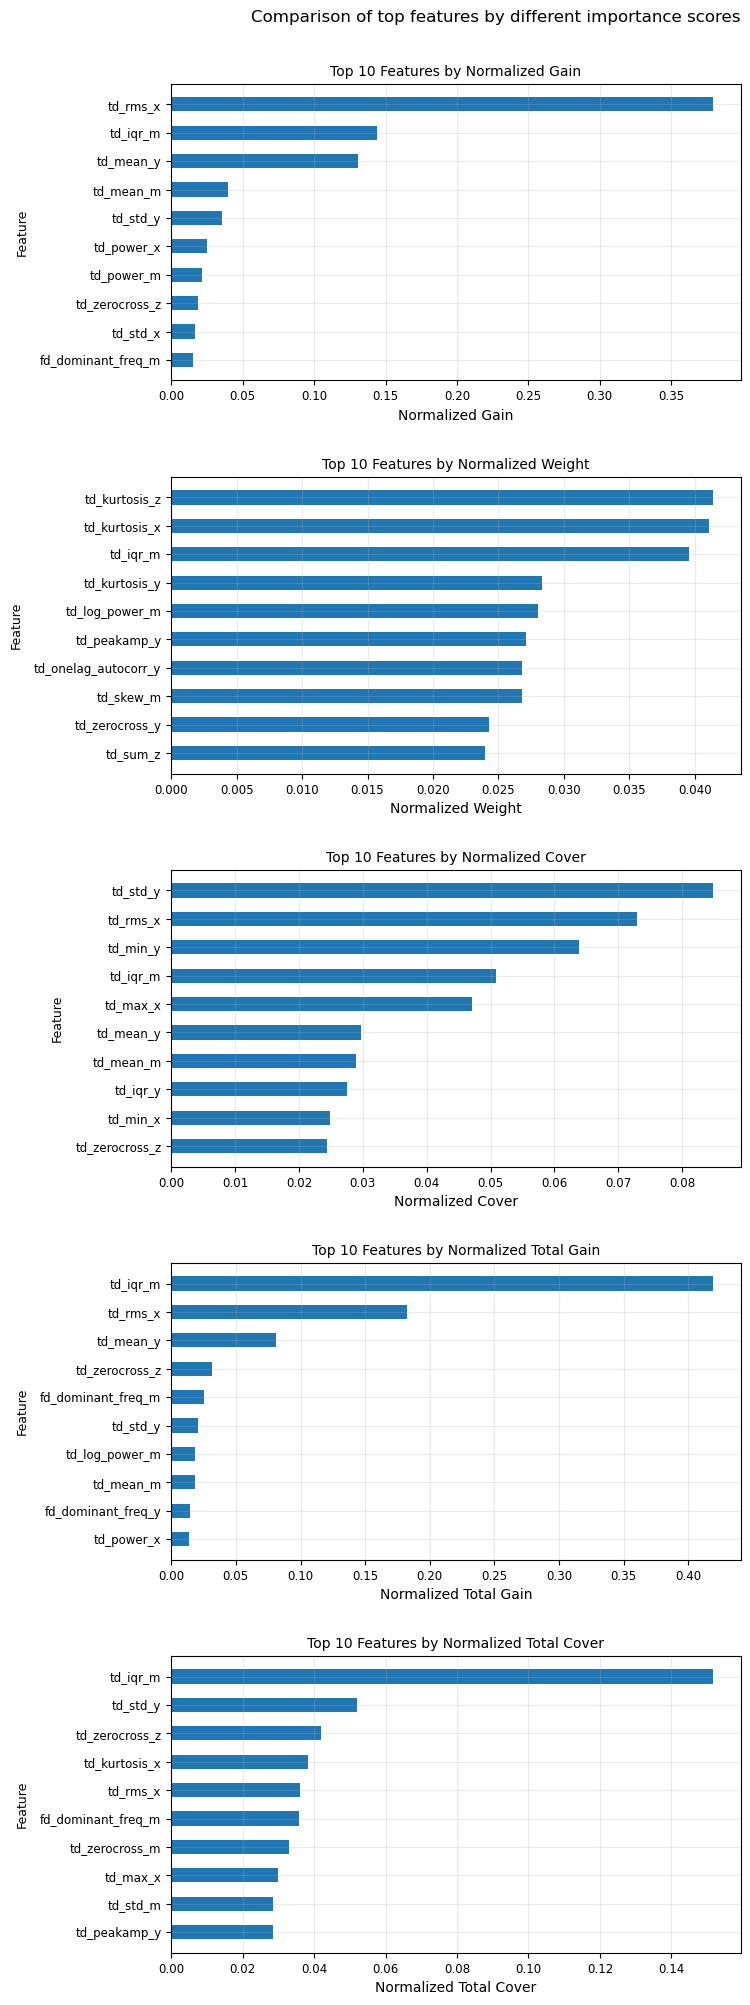

In [18]:
fig,ax = plt.subplots(len(scores_list),1,figsize=(8,20))
ax = ax.flatten()

for i in range(len(scores_list)):
    top10_df = scores_list[i].head(10)
    ax[i].barh(y=(top10_df.encoded_colname.tolist()[::-1]),
               width=(top10_df.score.tolist()[::-1]),
               height=0.5)
    ax[i].set_title('Top 10 Features by {}'.format(top10_df['score_type'].unique()[0]), 
                    fontsize=10)
    ax[i].set_xlabel('{}'.format(top10_df['score_type'].unique()[0], 
                                 fontsize=9, labelpad=8))
    ax[i].set_ylabel('Feature',fontsize=9, labelpad=8)
    ax[i].tick_params(axis='both', which='major', labelsize=8.5)
    ax[i].grid(alpha=0.25)

fig.tight_layout(pad=2.5)
fig.suptitle('Comparison of top features by different importance scores', 
             x=0.65, y=1.01, fontsize=12)
file_name = 'top10-xgb-importance.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

#### 4.3 Global Feature Importance (SHAP)

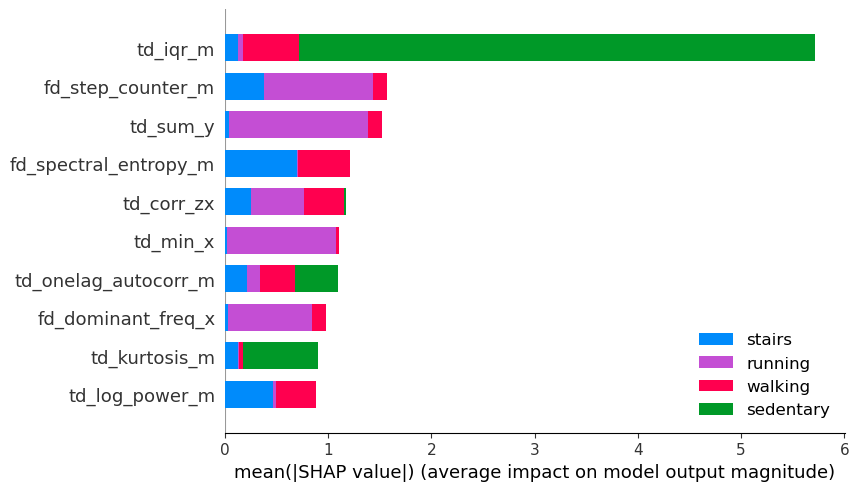

In [19]:
explainer = shap.TreeExplainer(reference_xgb_booster)
shap_values = explainer.shap_values(X_test.values)

shap.summary_plot(shap_values, features=X_test, 
                  feature_names = xgb_pipe[0].get_feature_names_out(),
                  max_display=10, plot_type='bar', class_names=reference_xgb.classes_,
                  show=False)
file_name = 'shap-global-fi.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")


### 5. Local Feature Importance (SHAP)

In [28]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


activity_class_idx = 3
activity_class = reference_xgb.classes_[activity_class_idx]
point_idx = 3

expected_values_log_odds = explainer.expected_value
expected_values_prob = softmax(expected_values_log_odds)
class_log_odds = np.sum(np.array([shap_values[0][point_idx],shap_values[1][point_idx],
                                  shap_values[2][point_idx],shap_values[3][point_idx]]),axis=1)+explainer.expected_value
class_prob = softmax(class_log_odds)


print("""Log odds for class \'{}\'= {:.3f}; corresponding predicted probability is {:.3f}. 
Expected value (in probability) of \'{}\' is {:.3f}"""\
      .format(activity_class, class_log_odds[activity_class_idx], class_prob[activity_class_idx],
              activity_class, expected_values_prob[activity_class_idx]))

fig = shap.force_plot(expected_values_log_odds[activity_class_idx], shap_values[activity_class_idx][point_idx], 
                features = X_test.iloc[point_idx], feature_names = X_test.columns, matplotlib=True, show=False)

file_name = 'local-importance-point1-walking.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

shap.force_plot(expected_values_log_odds[activity_class_idx], shap_values[activity_class_idx][point_idx], 
                features = X_test.iloc[point_idx], feature_names = X_test.columns)



Log odds for class 'walking'= 2.239; corresponding predicted probability is 0.882. 
Expected value (in probability) of 'walking' is 0.511


In [29]:
activity_class_idx = 2
activity_class = reference_xgb.classes_[activity_class_idx]
point_idx = 3

expected_values_log_odds = explainer.expected_value
expected_values_prob = softmax(expected_values_log_odds)
class_log_odds = np.sum(np.array([shap_values[0][point_idx],shap_values[1][point_idx],
                                  shap_values[2][point_idx],shap_values[3][point_idx]]),axis=1)+explainer.expected_value
class_prob = softmax(class_log_odds)


print("""Log odds for class \'{}\'= {:.3f}; corresponding predicted probability is {:.3f}. 
Expected value (in probability) of \'{}\' is {:.3f}"""\
      .format(activity_class, class_log_odds[activity_class_idx], class_prob[activity_class_idx],
              activity_class, expected_values_prob[activity_class_idx]))

shap.force_plot(expected_values_log_odds[activity_class_idx], shap_values[activity_class_idx][point_idx], 
                features = X_test.iloc[point_idx], feature_names = X_test.columns, matplotlib=True, show=False)

file_name = 'local-importance-point1-stairs.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

shap.force_plot(expected_values_log_odds[activity_class_idx], shap_values[activity_class_idx][point_idx], 
                features = X_test.iloc[point_idx], feature_names = X_test.columns)



Log odds for class 'stairs'= -3.496; corresponding predicted probability is 0.003. 
Expected value (in probability) of 'stairs' is 0.123


In [30]:
activity_class_idx = 0
activity_class = reference_xgb.classes_[activity_class_idx]
point_idx = 12

expected_values_log_odds = explainer.expected_value
expected_values_prob = softmax(expected_values_log_odds)
class_log_odds = np.sum(np.array([shap_values[0][point_idx],shap_values[1][point_idx],
                                  shap_values[2][point_idx],shap_values[3][point_idx]]),axis=1)+explainer.expected_value
class_prob = softmax(class_log_odds)


print("""Log odds for class \'{}\'= {:.3f}; corresponding predicted probability is {:.3f}. 
Expected value (in probability) of \'{}\' is {:.3f}"""\
      .format(activity_class, class_log_odds[activity_class_idx], class_prob[activity_class_idx],
              activity_class, expected_values_prob[activity_class_idx]))

shap.force_plot(expected_values_log_odds[activity_class_idx], shap_values[activity_class_idx][point_idx], 
                features = X_test.iloc[point_idx], feature_names = X_test.columns, matplotlib=True, show=False)

file_name = 'local-importance-point2-running.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

shap.force_plot(expected_values_log_odds[activity_class_idx], shap_values[activity_class_idx][point_idx], 
                features = X_test.iloc[point_idx], feature_names = X_test.columns)




Log odds for class 'running'= 0.232; corresponding predicted probability is 0.259. 
Expected value (in probability) of 'running' is 0.062


In [31]:
activity_class_idx = 2
activity_class = reference_xgb.classes_[activity_class_idx]
point_idx = 12

expected_values_log_odds = explainer.expected_value
expected_values_prob = softmax(expected_values_log_odds)
class_log_odds = np.sum(np.array([shap_values[0][point_idx],shap_values[1][point_idx],
                                  shap_values[2][point_idx],shap_values[3][point_idx]]),axis=1)+explainer.expected_value
class_prob = softmax(class_log_odds)


print("""Log odds for class \'{}\'= {:.3f}; corresponding predicted probability is {:.3f}. 
Expected value (in probability) of \'{}\' is {:.3f}"""\
      .format(activity_class, class_log_odds[activity_class_idx], class_prob[activity_class_idx],
              activity_class, expected_values_prob[activity_class_idx]))

shap.force_plot(expected_values_log_odds[activity_class_idx], shap_values[activity_class_idx][point_idx], 
                features = X_test.iloc[point_idx], feature_names = X_test.columns, matplotlib=True, show=False)

file_name = 'local-importance-point2-stairs.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")

shap.force_plot(expected_values_log_odds[activity_class_idx], shap_values[activity_class_idx][point_idx], 
                features = X_test.iloc[point_idx], feature_names = X_test.columns)


Log odds for class 'stairs'= 0.091; corresponding predicted probability is 0.225. 
Expected value (in probability) of 'stairs' is 0.123
